# Experiments with Fitzpatrick17K

To avoid further confusion by libraries' dependency, we resized the image's height from 450 and width from 600 to 300 and 300 pixels, respectively.

In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import imageprocessing
from imageprocessing import ImageResize, MaskedImage
from kerasmodels import CreateGenerator, CNNModel
import attacks
import preprocess_ham
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

2024-07-21 00:34:46.241266: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 00:34:46.368506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 00:34:47.121395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


## Load data

In [2]:
db = "FITZ"
root = f"../../dataset/IEEE/{db}/"

train_df = pd.read_csv(f"{root}exp/train_df.csv")
valid_df = pd.read_csv(f"{root}exp/valid_df.csv")
test_df = pd.read_csv(f"{root}exp/test_df.csv")

In [3]:
train_df["labels"] = train_df["labels"].astype(str)
valid_df["labels"] = valid_df["labels"].astype(str)
test_df["labels"] = test_df["labels"].astype(str)

## Create image generator

In [4]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = imageprocessing.get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [5]:
batch_size=8
img_size = img_size
cg = CreateGenerator(img_size, batch_size)
train_gen = cg.train_generator(train_df)
valid_gen = cg.valid_generator(valid_df)
test_gen = cg.valid_generator(test_df)

Found 2000 validated image filenames belonging to 2 classes.
Found 864 validated image filenames belonging to 2 classes.
Found 864 validated image filenames belonging to 2 classes.


## Training

In [6]:
import torch
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the ResNet50 model with pre-trained ImageNet weights, excluding the top fully connected layer
base_model = ResNet50(weights="imagenet", include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(Adam(learning_rate= 0.00001), loss= "binary_crossentropy", metrics= ["accuracy"])
model.summary()

2024-07-21 00:34:48.693967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 00:34:48.696566: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 00:34:48.696599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 00:34:48.700517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 00:34:48.700550: I external/local_xla/xla/stream_executor

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/20


/home/kuniko/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721518512.276527 3085622 service.cc:145] XLA service 0x7f3ac8002320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721518512.276625 3085622 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-21 00:35:12.687138: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-21 00:35:14.682153: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:17

250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 66ms/step - accuracy: 0.6012 - loss: 0.6717 - val_accuracy: 0.4977 - val_loss: 0.8231
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.7568 - loss: 0.5250 - val_accuracy: 0.4988 - val_loss: 2.8414
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8070 - loss: 0.4338 - val_accuracy: 0.4549 - val_loss: 1.4625
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8418 - loss: 0.3858 - val_accuracy: 0.6134 - val_loss: 0.9621
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.8325 - loss: 0.3688 - val_accuracy: 0.7419 - val_loss: 0.6207
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9023 - loss: 0.2757 - val_accuracy: 0.7905 - val_loss: 0.5274
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8947 - loss: 0.2504 - val_accuracy: 0.7998 - val_loss: 0.4875
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9226 - loss: 0.2058 - val_accurac

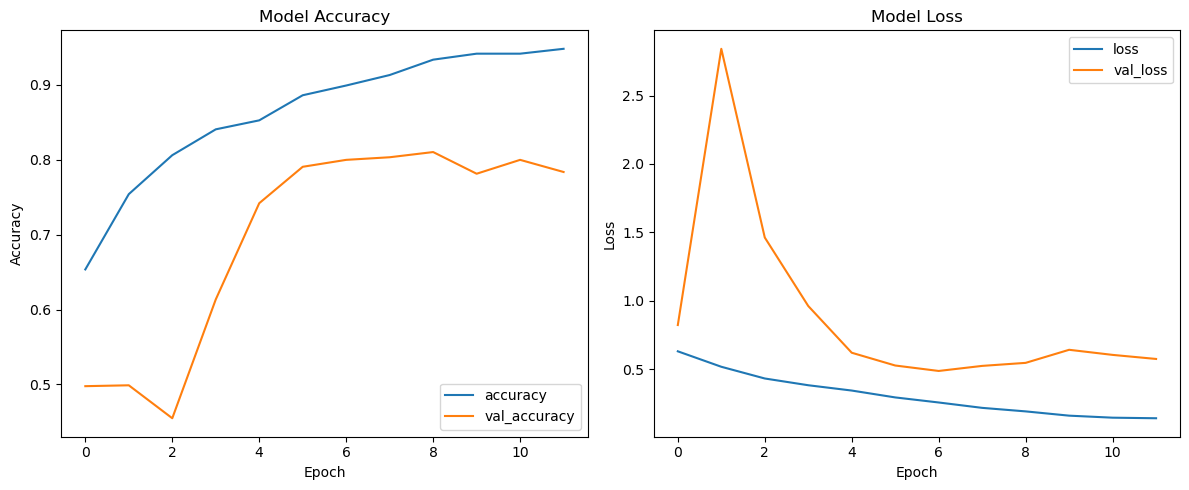

In [7]:
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[callback])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].plot(history.history["accuracy"], label="accuracy")
ax[0].plot(history.history["val_accuracy"], label="val_accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="lower right")
ax[0].set_title("Model Accuracy")

# Loss
ax[1].plot(history.history["loss"], label="loss")
ax[1].plot(history.history["val_loss"], label="val_loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper right")
ax[1].set_title("Model Loss")

plt.tight_layout()
plt.show()

In [8]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)
pred = model.predict(test_gen, verbose=0)
pred_class = ["1" if p[0] >= 0.5 else "0" for p in pred]

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8215 - loss: 0.4670
Test Loss 0.4590572714805603
Test Accuracy 0.8206018805503845


In [9]:
test_df["pred"] = pred_class
print(classification_report(test_df["labels"], test_df["pred"]))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       432
           1       0.82      0.82      0.82       432

    accuracy                           0.82       864
   macro avg       0.82      0.82      0.82       864
weighted avg       0.82      0.82      0.82       864



## Random Noise

True label: 1
Prediction: [[0.90552133]]
Prediction class: ['1']
Adversarial Prediction: [[0.7981022]]
Adversarial Predicted Class: ['1']


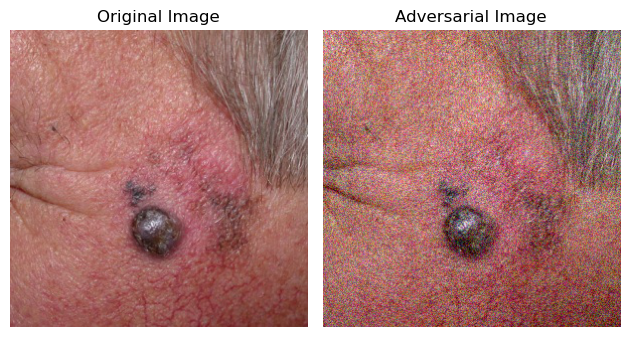

In [32]:
np.random.seed(42)
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.18
attacks.random_noise_attack_with_image(model, filepath, true_label, eps)

In [33]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.random_noise_attack(model, d["filepath"], d["labels"], eps))

In [34]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["RN pred"] = adv_pred
test_df["RN pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "RN")

RN Success rate: 0.24305555555555555
RN TN Success rate: 0.11805555555555555
RN FP Success rate: 0.125


## FGSM

True label: 1
Prediction: [[0.90552133]]
Prediction class: ['1']
Adversarial Prediction: [[1.4136253e-05]]
Adversarial Predicted Class: ['0']


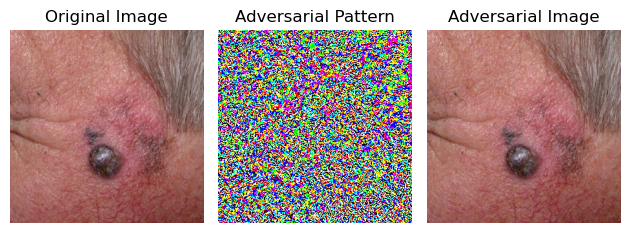

In [13]:
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.01
adv = attacks.fgsm_attack_with_image(model, filepath, true_label, eps)

In [14]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.fgsm_attack(model, d["filepath"], d["labels"], eps))

In [15]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["FGSM pred"] = adv_pred
test_df["FGSM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "FGSM")

FGSM Success rate: 0.7766203703703703
FGSM TN Success rate: 0.3726851851851852
FGSM FP Success rate: 0.4039351851851852


## Saliency Map Attack

True label: 1
Prediction: [[0.90552133]]
Prediction class: ['1']
Adversarial Prediction: [[0.99451876]]
Adversarial Predicted Class: ['1']


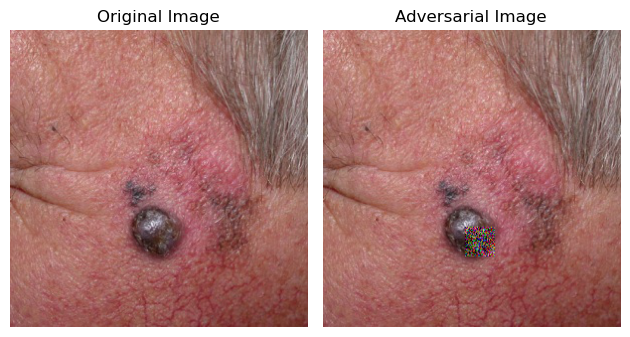

In [54]:
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.5
patch_size=30
attacks.sailency_attack_with_image(model, filepath, true_label, eps, patch_size)

In [55]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.saliency_attack(model, d["filepath"], d["labels"], eps, patch_size))

In [56]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["SM pred"] = adv_pred
test_df["SM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "SM")

SM Success rate: 0.12384259259259259
SM TN Success rate: 0.12152777777777778
SM FP Success rate: 0.0023148148148148147


## Data export for analysis

In [58]:
test_df.to_csv(f"{root}exp/test_df_Fitzpatrick17K_ResNet.csv", index=False)